# Siamese Networrk
***
This lab will go through creating and training a multi-input model. You will build a basic Siamese Network to find the similarity or dissimilarity between items of clothing. For Week 1, you will just focus on constructing the network. You will revisit this lab in Week 2 when we talk about custom loss functions.

### References
***
- [Learning a Similarity Metric Discriminatively, with Application to Face Verification](http://yann.lecun.com/exdb/publis/pdf/chopra-05.pdf) (Chopra, Hadsell, & LeCun, 2005)

- [Similarity Learning with (or without) Convolutional Neural Network](http://slazebni.cs.illinois.edu/spring17/lec09_similarity.pdf) (Chatterjee & Luo, n.d.)
- [The Distance Between Two Vectors](http://mathonline.wikidot.com/the-distance-between-two-vectors) (Mathonline)
- [Contrastive loss](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf) (from Hadsell-et-al.)
        

### Imports
***

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

### Prepare the dataset
***
First define a few utilities for preparing and visualizing your dataset.

In [2]:
def create_pairs(x, digit_indices):

  pairs, labels = [], []
  n = min([len(digit_indices[d]) for d in range(10)]) - 1
  
  for d in range(10):
    for i in range(n):
      z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
      pairs += [[x[z1], x[z2]]]
      inc = random.randrange(1, 10)
      dn = (d + inc) % 10
      z1, z2 = digit_indices[d][i], digit_indices[dn][i]
      pairs += [[x[z1], x[z2]]]
      labels += [1, 0]

  return np.array(pairs), np.array(labels)

In [3]:
def create_pairs_on_set(images, labels):

  digit_indices = [np.where(labels == i)[0] for i in range(10)]
  pairs, y = create_pairs(images, digit_indices)
  y = y.astype('float32')

  return pairs, y

In [4]:
def show_image(image):
  plt.figure()
  plt.imshow(image)
  plt.colorbar()
  plt.grid(False)
  plt.show

  return None

You can now download and prepare our train and test sets. You will also create pairs of images that will go into the multi-input model.

In [5]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [6]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = train_images / 255.
test_images = test_images / 255.

In [7]:
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

You can see a sampple pair of images below.

1.0


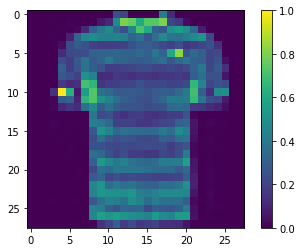

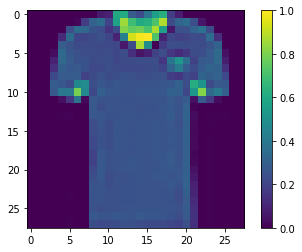

In [8]:
this_pair = 4

show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

print(tr_y[this_pair])

0.0


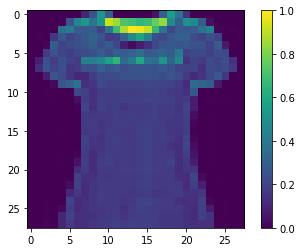

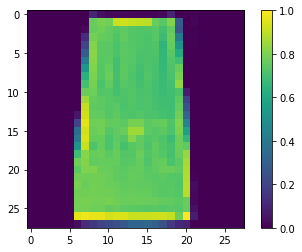

In [9]:
this_pair = 9

show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

print(tr_y[this_pair])

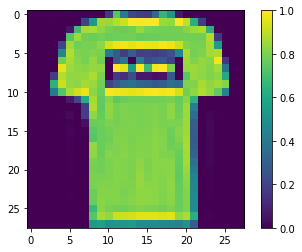

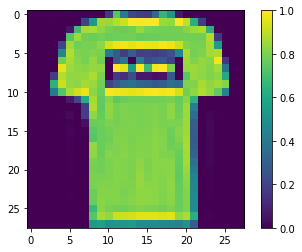

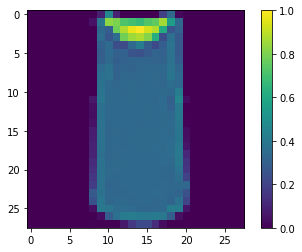

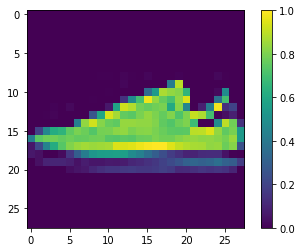

In [10]:
show_image(tr_pairs[:,0][0])
show_image(tr_pairs[:,0][1])

show_image(tr_pairs[:,1][0])
show_image(tr_pairs[:,1][1])

### Build the model
***
Next, you'll define some utilities for building our model.

In [11]:
def initialize_base_network():

  input = Input(shape=(28, 28), name='base_input')
  x = Flatten(name='flatten_input')(input)
  x = Dense(units=128, activation='relu', name='first_base_dense')(x)
  x = Dropout(0.1, name='first_dropout')(x)
  x = Dense(units=128, activation='relu', name='second_base_dense')(x)
  x = Dropout(0.1, name='second_dropout')(x)
  x = Dense(units=128, activation='relu', name='third_base_dense')(x)

  return Model(inputs=input, outputs=x)

In [12]:
def euclidian_distance(vects):

  x, y = vects
  sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)

  return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [13]:
def eucl_dist_output_shape(shapes):

  shape1, shape2 = shapes
  
  return (shapes1[0], 1)

Let's see how our base network looks. This is where the two inputs will pass through to generate an output vector.

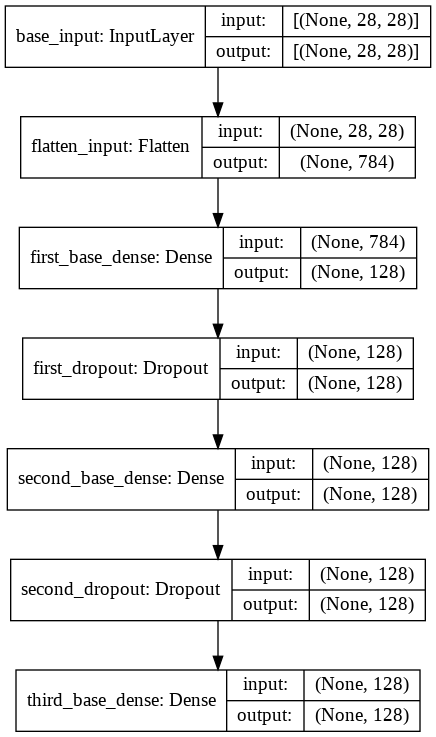

In [14]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

Let's now build the Siamese network. The plot will show two inputs going to the base network.

In [15]:
input_a = Input(shape=(28, 28), name='left_input')
vect_output_a = base_network(input_a)

input_b = Input(shape=(28, 28), name='right_input')
vect_output_b = base_network(input_b)

In [16]:
output = Lambda(euclidian_distance, name='output_layer', output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

In [17]:
model = Model(inputs=[input_a, input_b], outputs=output)

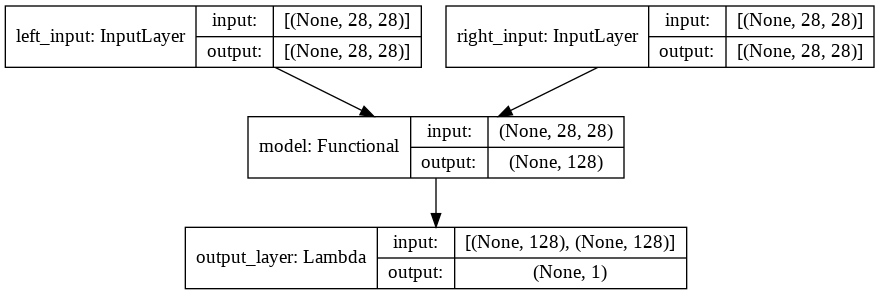

In [18]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

### Train the model
***
You can now define the custom loss for out network and start training. Don't worry about why it's written as a nested function just yet. You will revisit this in Week 2.

In [19]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [20]:
rms = RMSprop()
model.compile(loss = contrastive_loss_with_margin(margin=1), 
              optimizer=rms)

In [ ]:
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]],
                    tr_y, epochs=20, batch_size=128,
                    validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 [==============================] - 10s 10ms/step - loss: 0.1103 - val_loss: 0.0834
Epoch 2/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0784 - val_loss: 0.0754
Epoch 3/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0700 - val_loss: 0.0698
Epoch 4/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0654 - val_loss: 0.0675
Epoch 5/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0623 - val_loss: 0.0661
Epoch 6/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0600 - val_loss: 0.0661
Epoch 7/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0587 - val_loss: 0.0653
Epoch 8/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0575 - val_loss: 0.0687
Epoch 9/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0564 - val_loss: 0.0638
Epoch 10/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0552 - val_loss: 0

### Model evaluation
***
As usual, you can evaluate our modelo computing the accuracy and observing the metrics during training.

In [21]:
def compute_accuracy(y_true, y_pred):

  pred = y_pred.ravel() > 0.5

  return np.mean(pred == y_true)

In [ ]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}\nTrain Accuracy = {}\nTest Accuracy = {}".format(loss, -train_accuracy + 100, -test_accuracy + 100))

625/625 [==============================] - 1s 2ms/step - loss: 0.0635
Loss = 0.06348183006048203
Train Accuracy = 99.93843973995666
Test Accuracy = 99.91246246246246


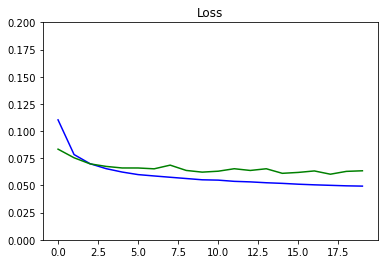

In [ ]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [ ]:
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')

def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') 
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

You can see sample results for 10 pairs of items below.

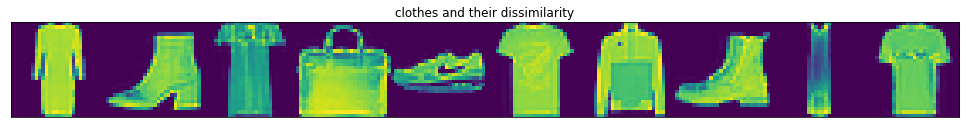

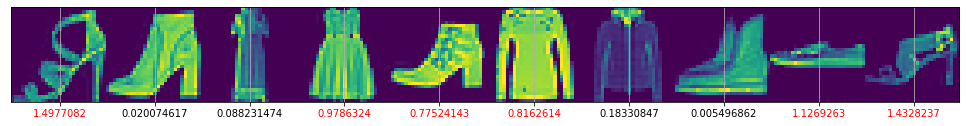

In [ ]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)